[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cataluna84/VisionInterpretability/blob/main/notebooks/cataluna84__segment_1_intro.ipynb)

# Segment 1: CNN Basics, Decoding CNNs & Interpretability

Welcome to this interactive tutorial on **Computer Vision** and **Convolutional Neural Networks (CNNs)**.

## What You'll Learn

1. **Image Representation** — How computers "see" images as tensors
2. **Convolution Operations** — The math behind edge detection, blur, and sharpening
3. **Building a CNN** — Train a model from scratch on ImageNette
4. **Feature Visualization** — See what patterns each layer detects
5. **Interpretability Methods** — Understand *why* a model makes predictions
   - Saliency Maps (Vanilla Gradients)
   - Grad-CAM (Class Activation Mapping)

Let's decode the black box! 🧠


In [1]:
# @title 🚀 Environment Setup (Run this cell first!)
# @markdown This cell sets up the environment for both Colab and local runs.

import sys
import os

# Check if running in Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🌐 Running in Google Colab")
    
    # Clone the repository if not already cloned
    if not os.path.exists('VisionInterpretability'):
        !git clone https://github.com/cataluna84/VisionInterpretability.git
    
    # Change to project directory
    os.chdir('VisionInterpretability')
    
    # Install dependencies
    !pip install -q torch torchvision matplotlib numpy pillow tqdm opencv-python requests
    
    # Add src to Python path
    sys.path.insert(0, 'src')
    print("✅ Colab setup complete!")
else:
    print("💻 Running locally")
    # For local runs, add src to path if running from notebooks directory
    if os.path.basename(os.getcwd()) == 'notebooks':
        sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))
    elif 'src' not in sys.path:
        sys.path.insert(0, 'src')
    print("✅ Local setup complete!")


💻 Running locally
✅ Local setup complete!


In [2]:
"""Import required libraries and custom modules."""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO

# Import our custom modules
from segment_1_intro import models, visualize, data

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")

# Visualization settings
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12


🖥️ Using device: cuda


## 1. How Images Are Represented

### Theoretical Background

Digital images are represented as **multi-dimensional arrays** (tensors) where each element corresponds to a pixel intensity. In deep learning frameworks like PyTorch, images follow the **CHW convention**:

$$\mathbf{X} \in \mathbb{R}^{C \times H \times W}$$

where:
- $C$ = Number of color channels (3 for RGB: Red, Green, Blue)
- $H$ = Height in pixels
- $W$ = Width in pixels

### Pixel Value Representation

| Format | Range | Description |
|--------|-------|-------------|
| Raw (uint8) | [0, 255] | Original image format |
| Normalized | [0, 1] | After `ToTensor()` transform |
| Standardized | ~[-2.5, 2.5] | After ImageNet normalization |

**ImageNet normalization** is standard for pretrained models:

$$x_{\text{norm}} = \frac{x - \mu}{\sigma}$$

where $\mu = [0.485, 0.456, 0.406]$ and $\sigma = [0.229, 0.224, 0.225]$ (per channel).

### Why This Matters

Understanding tensor representations is fundamental because:
1. **Convolutions** operate on spatial dimensions (H, W)
2. **Batch processing** adds a 4th dimension: $(N, C, H, W)$
3. **Interpretability methods** compute gradients with respect to these pixel values


Tensor Shape: torch.Size([3, 384, 512]) (C, H, W)
Value Range: [0.000, 1.000]


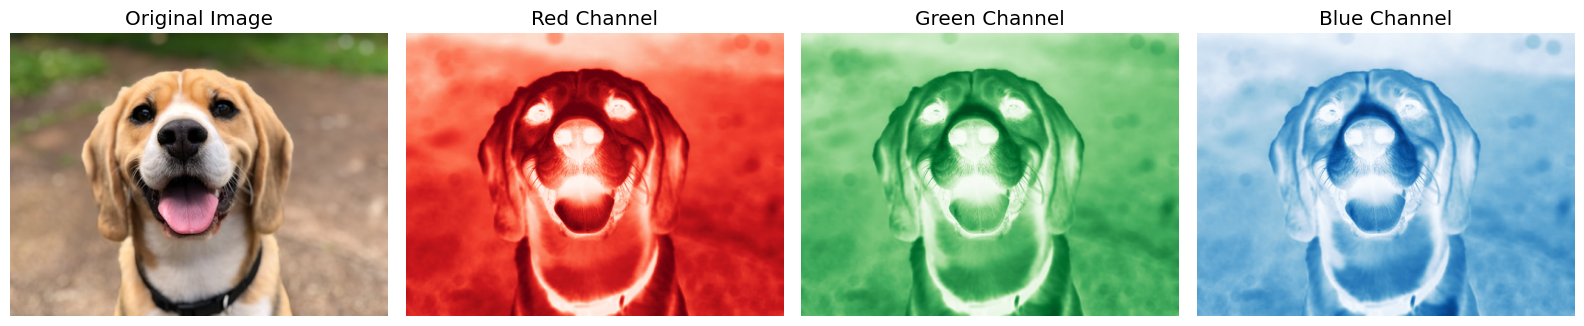

In [3]:
# Download a sample image
url = "https://images.unsplash.com/photo-1543466835-00a7907e9de1?ixlib=rb-4.0.3&q=85&fm=jpg&crop=entropy&cs=srgb&w=512"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('RGB')

# Display original image
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Convert to tensor and show individual channels
img_tensor = transforms.ToTensor()(img)
print(f"Tensor Shape: {img_tensor.shape} (C, H, W)")
print(f"Value Range: [{img_tensor.min():.3f}, {img_tensor.max():.3f}]")

# Show RGB channels
channel_names = ["Red Channel", "Green Channel", "Blue Channel"]
cmaps = ["Reds", "Greens", "Blues"]

for i, (name, cmap) in enumerate(zip(channel_names, cmaps)):
    axes[i+1].imshow(img_tensor[i], cmap=cmap)
    axes[i+1].set_title(name)
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()


## 2. Convolution Operations Deep Dive

### Mathematical Definition

A **2D convolution** (technically cross-correlation in deep learning) applies a kernel $\mathbf{K}$ to an input image $\mathbf{I}$ to produce an output feature map $\mathbf{S}$:

$$S(i, j) = (\mathbf{I} * \mathbf{K})(i, j) = \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} I(i+m, j+n) \cdot K(m, n)$$

where $M \times N$ is the kernel size.

### Output Size Calculation

Given input size $i$, kernel size $k$, stride $s$, and padding $p$:

$$o = \left\lfloor \frac{i + 2p - k}{s} \right\rfloor + 1$$

### Common Kernels and Their Effects

| Kernel | Purpose | Mathematical Property |
|--------|---------|----------------------|
| **Sobel** | Edge detection | Approximates gradient $\nabla I$ |
| **Laplacian** | All edges | Second derivative $\nabla^2 I$ |
| **Gaussian** | Blur/smoothing | Low-pass filter |
| **Sharpen** | Enhance edges | High-pass amplification |

### Sobel Operators

Detect horizontal and vertical edges:

$$G_x = \begin{bmatrix} -1 & 0 & +1 \\ -2 & 0 & +2 \\ -1 & 0 & +1 \end{bmatrix}, \quad G_y = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ +1 & +2 & +1 \end{bmatrix}$$

Edge magnitude: $G = \sqrt{G_x^2 + G_y^2}$

### Key Insight

> In CNNs, kernels are **learned** through backpropagation rather than hand-designed, allowing the network to discover optimal feature detectors for the task.


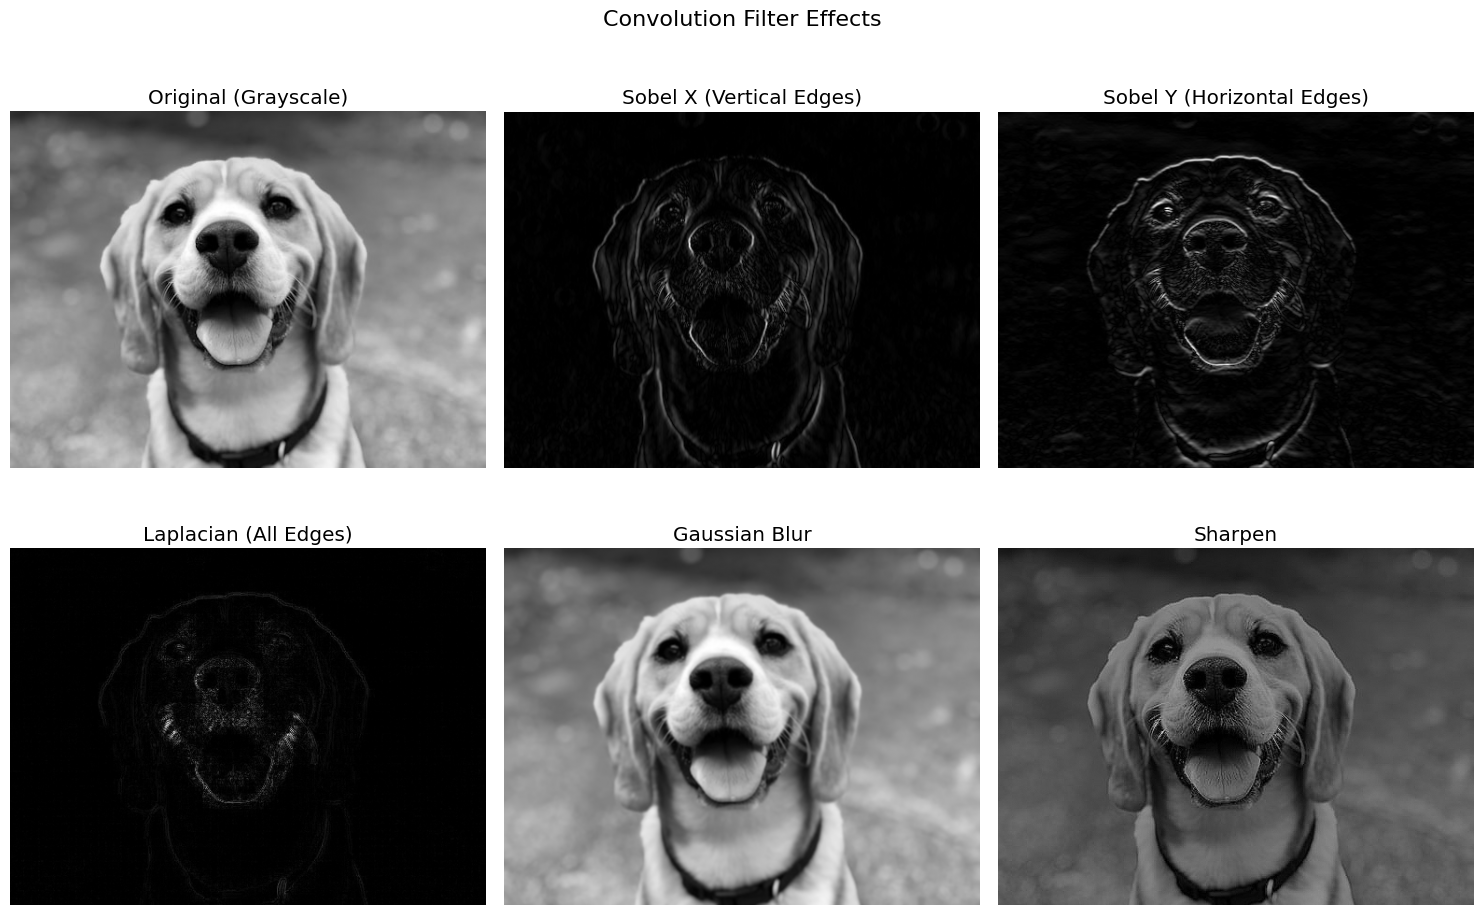

In [4]:
def manual_convolution(image_tensor, kernel):
    """
    Simple manual 2D convolution for demonstration.
    image_tensor: (1, H, W) -> Grayscale
    kernel: (K, K) -> Filter
    """
    c, h, w = image_tensor.shape
    kh, kw = kernel.shape
    output_h, output_w = h - kh + 1, w - kw + 1
    output = torch.zeros((output_h, output_w))
    
    for i in range(output_h):
        for j in range(output_w):
            region = image_tensor[0, i:i+kh, j:j+kw]
            output[i, j] = torch.sum(region * kernel)
    
    return output

# Define various filters
kernels = {
    "Sobel X (Vertical Edges)": torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32),
    "Sobel Y (Horizontal Edges)": torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32),
    "Laplacian (All Edges)": torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=torch.float32),
    "Gaussian Blur": torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=torch.float32) / 16,
    "Sharpen": torch.tensor([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=torch.float32),
}

# Convert to grayscale
gray_img = transforms.Grayscale()(img_tensor)

# Apply each filter
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

axes[0].imshow(gray_img.squeeze(), cmap='gray')
axes[0].set_title("Original (Grayscale)")
axes[0].axis('off')

for idx, (name, kernel) in enumerate(kernels.items(), 1):
    result = manual_convolution(gray_img, kernel)
    axes[idx].imshow(result.abs(), cmap='gray')
    axes[idx].set_title(name)
    axes[idx].axis('off')

plt.suptitle("Convolution Filter Effects", fontsize=16)
plt.tight_layout()
plt.show()


## 3. Building & Training a CNN on ImageNette

### CNN Architecture Theory

A Convolutional Neural Network learns a hierarchy of features through stacked layers:

$$\mathbf{h}^{(l)} = \sigma\left(\mathbf{W}^{(l)} * \mathbf{h}^{(l-1)} + \mathbf{b}^{(l)}\right)$$

where:
- $\mathbf{h}^{(l)}$ = Activation at layer $l$
- $\mathbf{W}^{(l)}$ = Learnable convolution kernels
- $\sigma$ = Non-linear activation (e.g., ReLU)
- $*$ = Convolution operation

### The Feature Hierarchy

Research by Zeiler & Fergus (2014) and Olah et al. (2017) shows:

| Layer Depth | Features Learned | Examples |
|-------------|-----------------|----------|
| Layer 1 | Low-level | Edges, colors, gradients |
| Layer 2-3 | Mid-level | Textures, patterns, curves |
| Layer 4+ | High-level | Object parts, faces, wheels |
| Final | Semantic | Full objects, scenes |

### ImageNette Dataset

A subset of ImageNet with 10 easily classifiable classes:

| Class | ImageNet ID | Category |
|-------|------------|----------|
| Tench | n01440764 | Fish |
| English Springer | n02102040 | Dog |
| Cassette Player | n02979186 | Electronics |
| Chain Saw | n03000684 | Tool |
| Church | n03028079 | Building |
| French Horn | n03394916 | Instrument |
| Garbage Truck | n03417042 | Vehicle |
| Gas Pump | n03425413 | Object |
| Golf Ball | n03445777 | Sports |
| Parachute | n03888257 | Equipment |

### Training Objective

We minimize the **Cross-Entropy Loss**:

$$\mathcal{L} = -\sum_{c=1}^{C} y_c \log(\hat{y}_c)$$

where $y_c$ is the one-hot target and $\hat{y}_c$ is the predicted probability for class $c$.


In [5]:
# Load ImageNette dataset from fast.ai S3
print("📦 Loading ImageNette dataset from fast.ai S3...")
train_loader = data.load_imagenette(split="train", image_size=320, batch_size=64)
val_loader = data.load_imagenette(split="validation", image_size=320, batch_size=64)

print(f"✅ Training samples: ~{len(train_loader) * 64}")
print(f"✅ Validation samples: ~{len(val_loader) * 64}")
print(f"📋 Classes: {data.IMAGENETTE_CLASSES}")


📦 Loading ImageNette dataset from fast.ai S3...
✅ Loaded ImageNette train (320px): 9469 samples, 10 classes
✅ Loaded ImageNette val (320px): 3925 samples, 10 classes
✅ Training samples: ~9472
✅ Validation samples: ~3968
📋 Classes: ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']


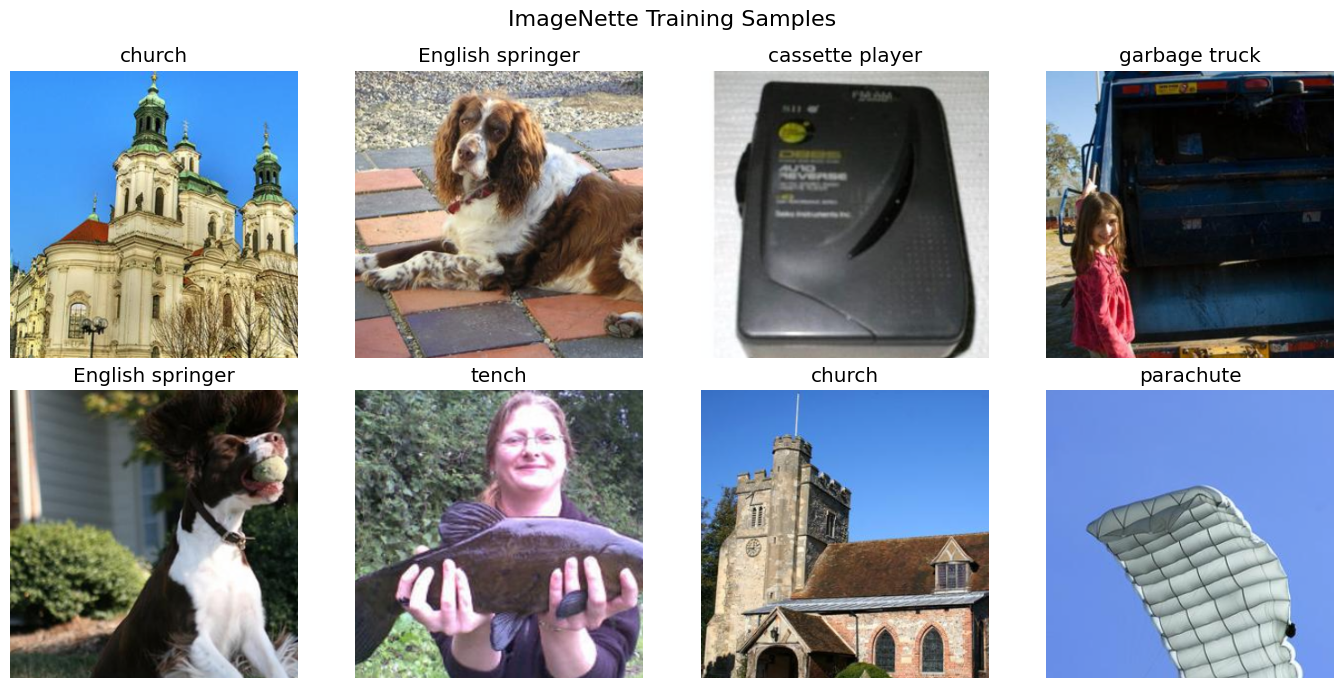

In [6]:
# Visualize some training samples
sample_images, sample_labels = data.get_sample_images(train_loader, num_samples=8)
classes = data.IMAGENETTE_CLASSES

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
for i, ax in enumerate(axes.flat):
    img = visualize.denormalize_image(sample_images[i])
    ax.imshow(img)
    ax.set_title(classes[sample_labels[i]])
    ax.axis('off')

plt.suptitle("ImageNette Training Samples", fontsize=16)
plt.tight_layout()
plt.show()


In [7]:
# Create our SimpleCNN model
model = models.load_simple_cnn(num_classes=10)
print(model)
print(f"\n📊 Total Parameters: {sum(p.numel() for p in model.parameters()):,}")


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

📊 Total Parameters: 1,147,914


### Training the Model

Training uses the **Adam optimizer**, which adapts learning rates per-parameter:

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t$$

where $\hat{m}_t$ and $\hat{v}_t$ are bias-corrected first and second moment estimates.

⚠️ **Note**: Training takes a few minutes. For a quick demo, we train for just 3 epochs.
In practice, you'd train for 20+ epochs to achieve better accuracy.


In [8]:
# Train the model (reduced epochs for demo)
EPOCHS = 20  # Increase to 10-20 for better results

print(f"🚀 Training SimpleCNN for {EPOCHS} epochs...")
history = models.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    learning_rate=0.001,
    device=device,
    show_progress=True
)

print("\n✅ Training complete!")


🚀 Training SimpleCNN for 20 epochs...

Epoch 1/20
------------------------------


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Train Loss: 1.6986 | Train Acc: 41.75%


Val Loss: 1.3699   | Val Acc: 55.24%

Epoch 2/20
------------------------------


Train Loss: 1.2626 | Train Acc: 57.58%


Val Loss: 1.4104   | Val Acc: 55.77%

Epoch 3/20
------------------------------


Train Loss: 1.1241 | Train Acc: 63.53%


Val Loss: 1.0981   | Val Acc: 65.10%

Epoch 4/20
------------------------------


Train Loss: 1.0509 | Train Acc: 66.04%


Val Loss: 1.0832   | Val Acc: 65.30%

Epoch 5/20
------------------------------


Train Loss: 0.9960 | Train Acc: 67.68%


Val Loss: 0.9169   | Val Acc: 71.24%

Epoch 6/20
------------------------------


Train Loss: 0.9410 | Train Acc: 70.19%


Val Loss: 0.9444   | Val Acc: 69.50%

Epoch 7/20
------------------------------


Train Loss: 0.9206 | Train Acc: 70.29%


Val Loss: 0.9038   | Val Acc: 70.78%

Epoch 8/20
------------------------------


Train Loss: 0.8720 | Train Acc: 71.89%


Val Loss: 0.9049   | Val Acc: 71.77%

Epoch 9/20
------------------------------


Train Loss: 0.8486 | Train Acc: 73.21%


Val Loss: 0.9222   | Val Acc: 70.68%

Epoch 10/20
------------------------------


Train Loss: 0.8239 | Train Acc: 73.01%


Val Loss: 1.0792   | Val Acc: 67.59%

Epoch 11/20
------------------------------


Train Loss: 0.8175 | Train Acc: 74.27%


Val Loss: 0.9976   | Val Acc: 69.22%

Epoch 12/20
------------------------------


Train Loss: 0.7674 | Train Acc: 74.80%


Val Loss: 1.4216   | Val Acc: 59.16%

Epoch 13/20
------------------------------


Train Loss: 0.7535 | Train Acc: 75.71%


Val Loss: 0.7872   | Val Acc: 74.90%

Epoch 14/20
------------------------------


Train Loss: 0.7453 | Train Acc: 75.68%


Val Loss: 0.7851   | Val Acc: 74.75%

Epoch 15/20
------------------------------


Train Loss: 0.7285 | Train Acc: 76.58%


Val Loss: 0.7781   | Val Acc: 75.01%

Epoch 16/20
------------------------------


Train Loss: 0.7141 | Train Acc: 77.08%


Val Loss: 0.7740   | Val Acc: 75.85%

Epoch 17/20
------------------------------


Train Loss: 0.6960 | Train Acc: 77.29%


Val Loss: 0.8856   | Val Acc: 72.92%

Epoch 18/20
------------------------------


Train Loss: 0.6635 | Train Acc: 78.41%


Val Loss: 0.7433   | Val Acc: 76.97%

Epoch 19/20
------------------------------


Train Loss: 0.6497 | Train Acc: 79.01%


Val Loss: 1.3638   | Val Acc: 63.82%

Epoch 20/20
------------------------------


Train Loss: 0.6429 | Train Acc: 79.42%


Val Loss: 1.0104   | Val Acc: 68.99%

✅ Training complete!


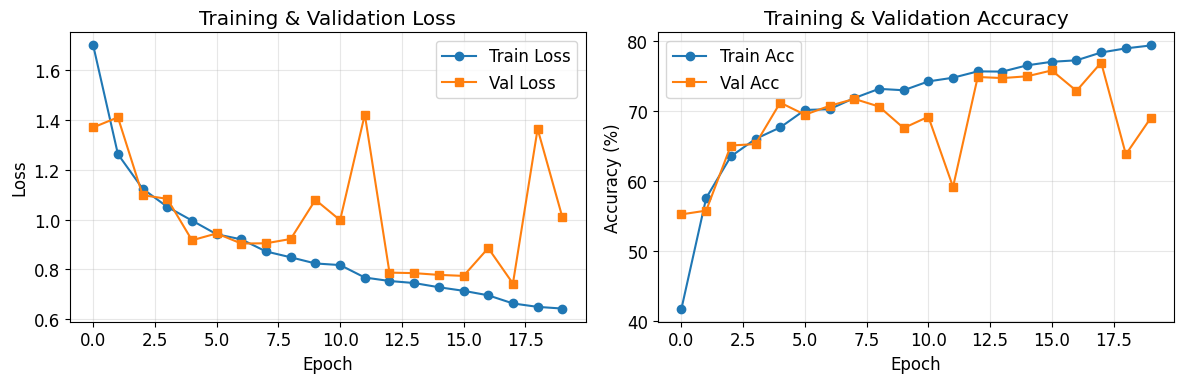

In [9]:
# Plot training history
visualize.plot_training_history(history)


## 4. Feature Map Visualization

### What Are Feature Maps?

**Feature maps** (activation maps) are the outputs of convolutional layers. For a layer with $K$ filters:

$$\mathbf{A}^k = \sigma(\mathbf{W}^k * \mathbf{X} + b^k), \quad k = 1, \ldots, K$$

Each feature map $\mathbf{A}^k$ highlights regions where specific patterns are detected.

### Interpretation by Layer

| Layer | Feature Map Shows | Spatial Resolution |
|-------|------------------|-------------------|
| `conv1` | Edges, color blobs | High (close to input) |
| `conv2` | Texture patterns | Medium |
| `conv3` | Object parts | Low (more abstract) |

### Why Visualize Feature Maps?

1. **Debugging**: Verify the network is learning meaningful features
2. **Interpretation**: Understand *where* the network focuses attention
3. **Research**: Analyze the feature hierarchy in novel architectures

> *"Early layers detect low-level features (edges, colors, textures). Later layers detect high-level concepts (object parts, shapes)."* — Zeiler & Fergus, 2014


Analyzing image of: church

conv1 output shape: torch.Size([1, 32, 320, 320])


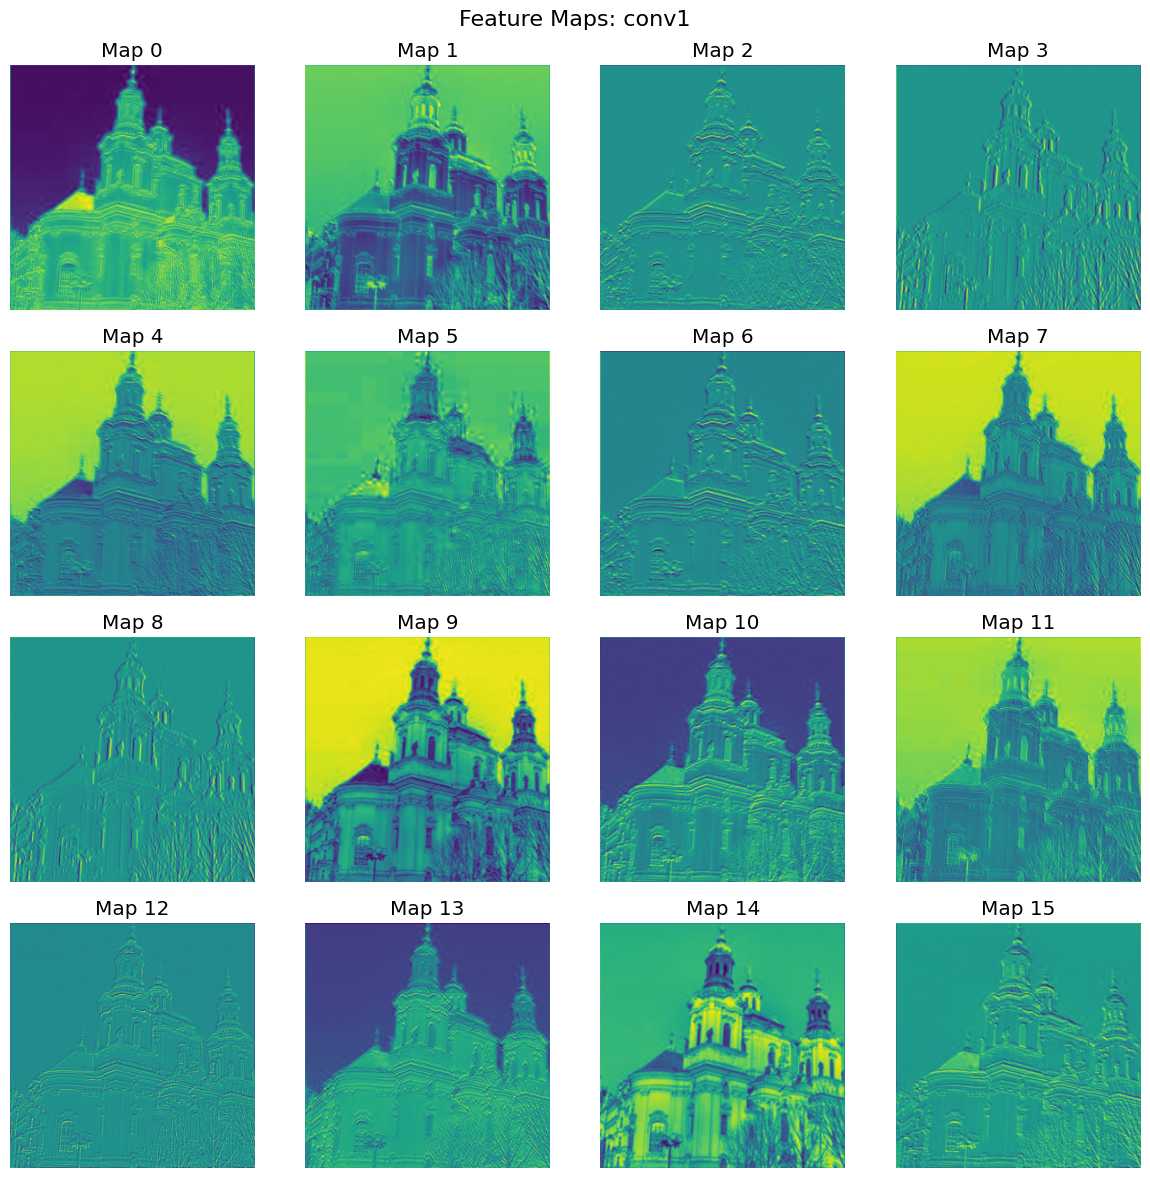


conv2 output shape: torch.Size([1, 64, 160, 160])


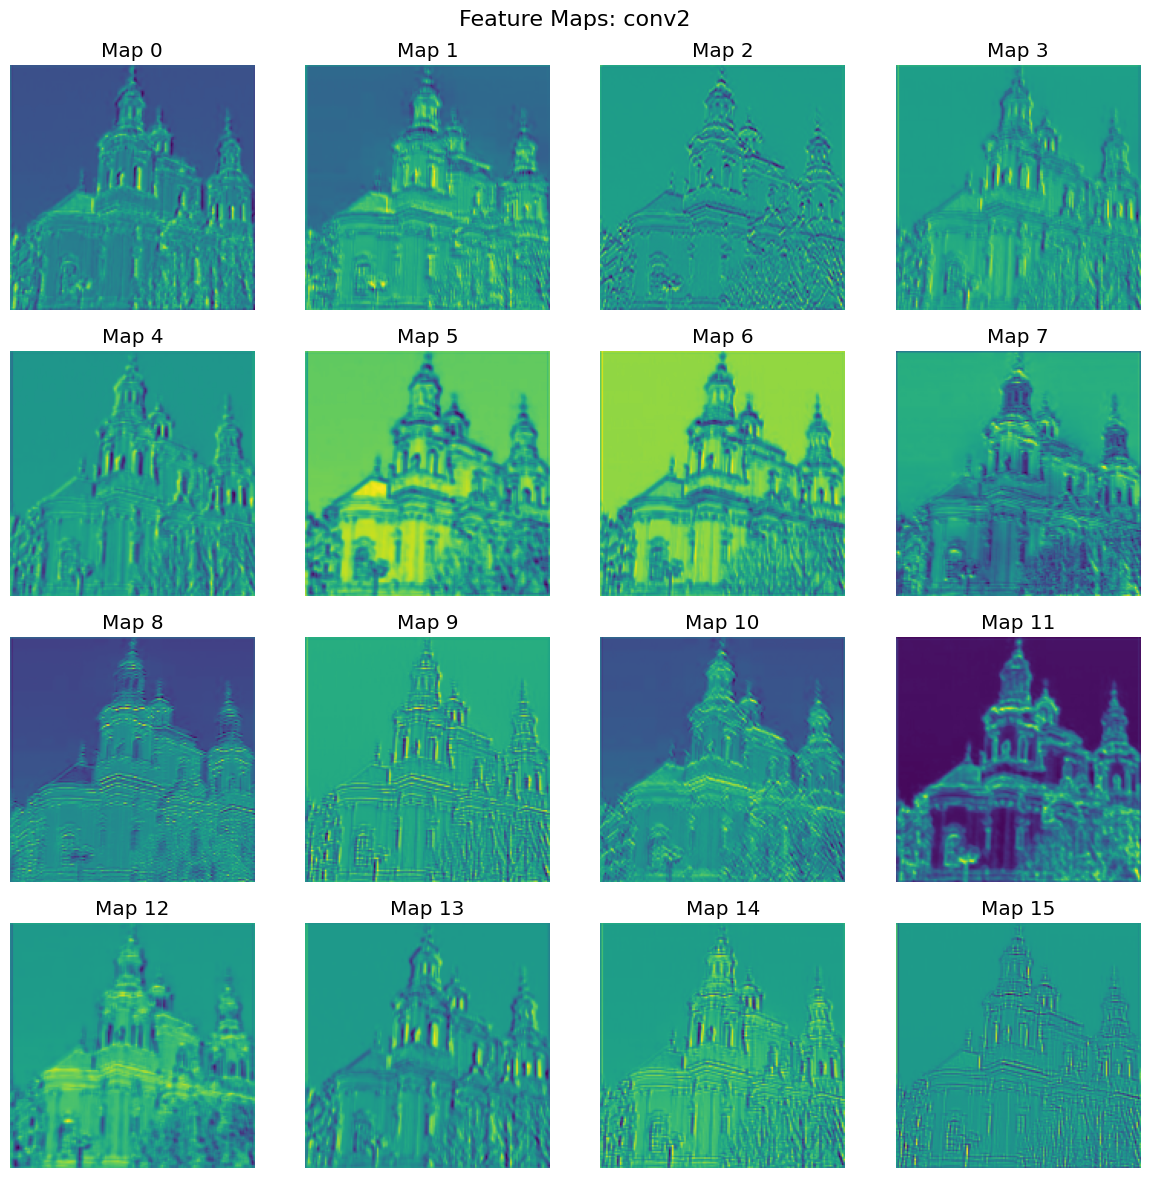


conv3 output shape: torch.Size([1, 128, 80, 80])


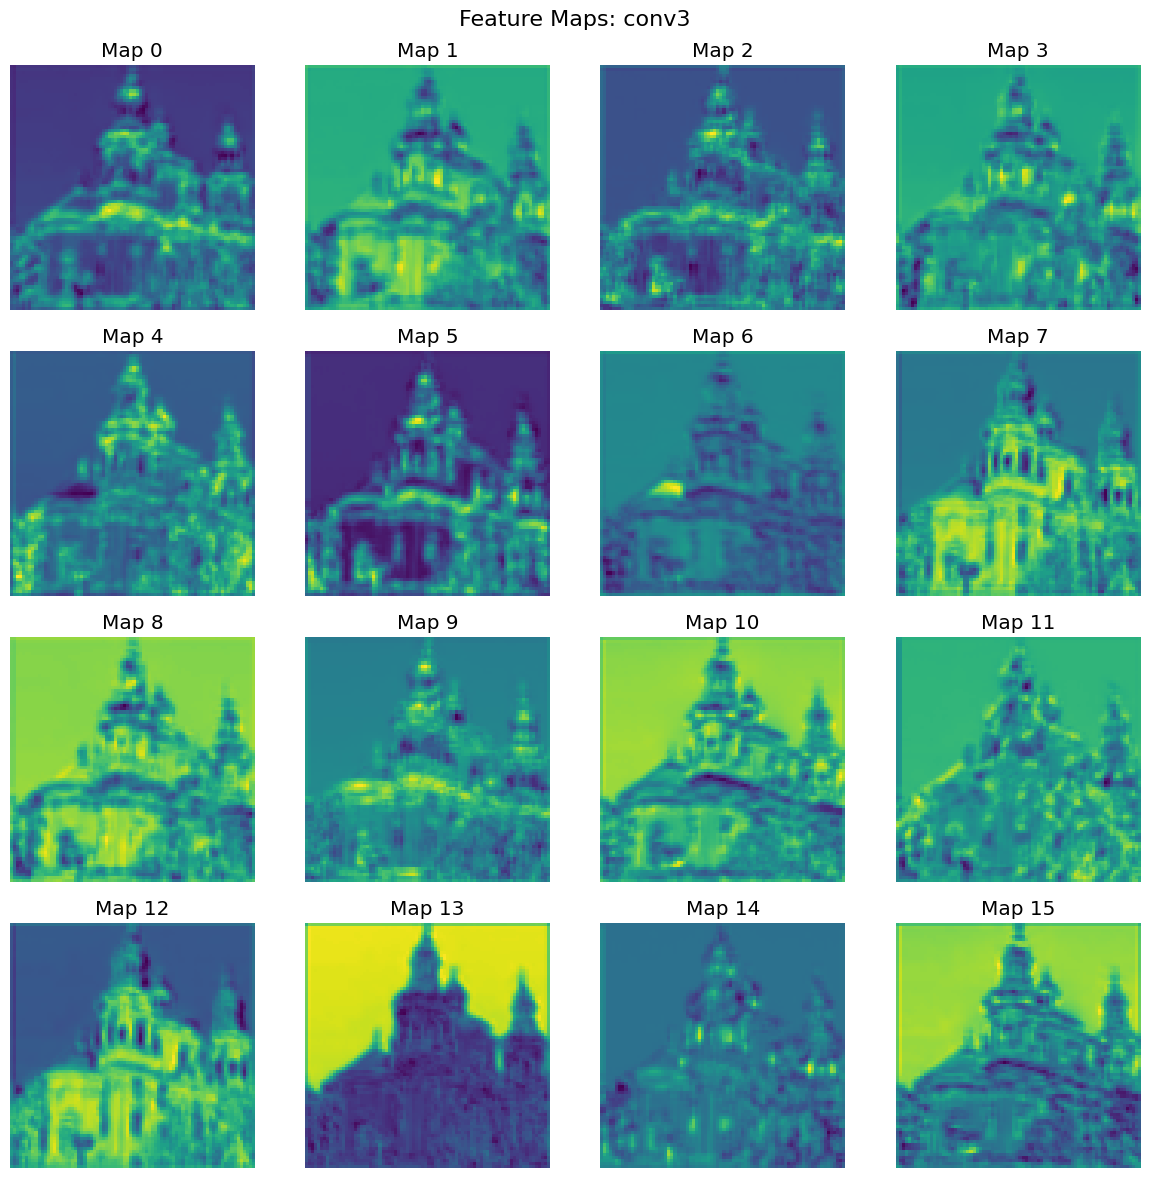

In [10]:
# Get a sample image for visualization
sample_img, sample_label = sample_images[0:1], sample_labels[0]
print(f"Analyzing image of: {classes[sample_label]}")

# Register hooks to capture activations
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks on each conv layer
model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.conv3.register_forward_hook(get_activation('conv3'))

# Forward pass
model.eval()
with torch.no_grad():
    _ = model(sample_img.to(device))

# Visualize feature maps from each layer
for layer_name in ['conv1', 'conv2', 'conv3']:
    acts = activations[layer_name].cpu()
    print(f"\n{layer_name} output shape: {acts.shape}")
    visualize.visualize_feature_maps(acts, num_maps=16, title=f"Feature Maps: {layer_name}")


## 5. Filter (Kernel) Visualization

### Theory: What Filters Learn

Convolutional filters are the **learned parameters** $\mathbf{W} \in \mathbb{R}^{C_{out} \times C_{in} \times k \times k}$.

For the **first layer** (RGB input with $C_{in}=3$), each filter can be visualized as a small RGB image showing what pattern the filter responds to.

### Trained vs. Random Filters

| Filter Type | Appearance | Interpretation |
|-------------|-----------|----------------|
| **Random (untrained)** | Noise-like | No meaningful patterns |
| **Trained** | Structure | Edge detectors, color selectivity |

### Common First-Layer Filter Types

After training, first-layer filters typically include:
- **Gabor-like filters**: Oriented edges at various angles
- **Color-opponent filters**: Red-green, blue-yellow channels
- **Gradient filters**: Similar to Sobel operators

This emergence is consistent across different CNN architectures and datasets.


First Layer Filters (RGB - what patterns is the model looking for?):


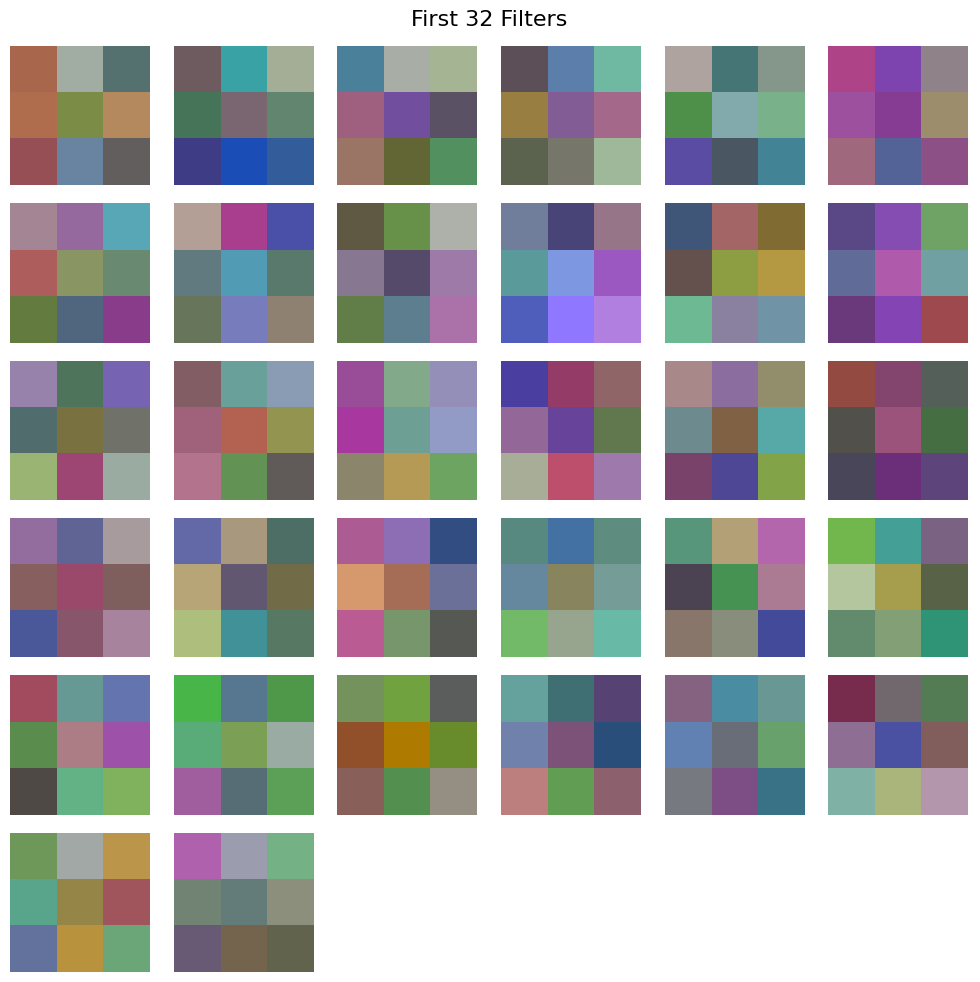

In [11]:
# Visualize learned filters from the first conv layer
print("First Layer Filters (RGB - what patterns is the model looking for?):")
visualize.visualize_filters(model.conv1, num_filters=32)


Random (Untrained) Filters:


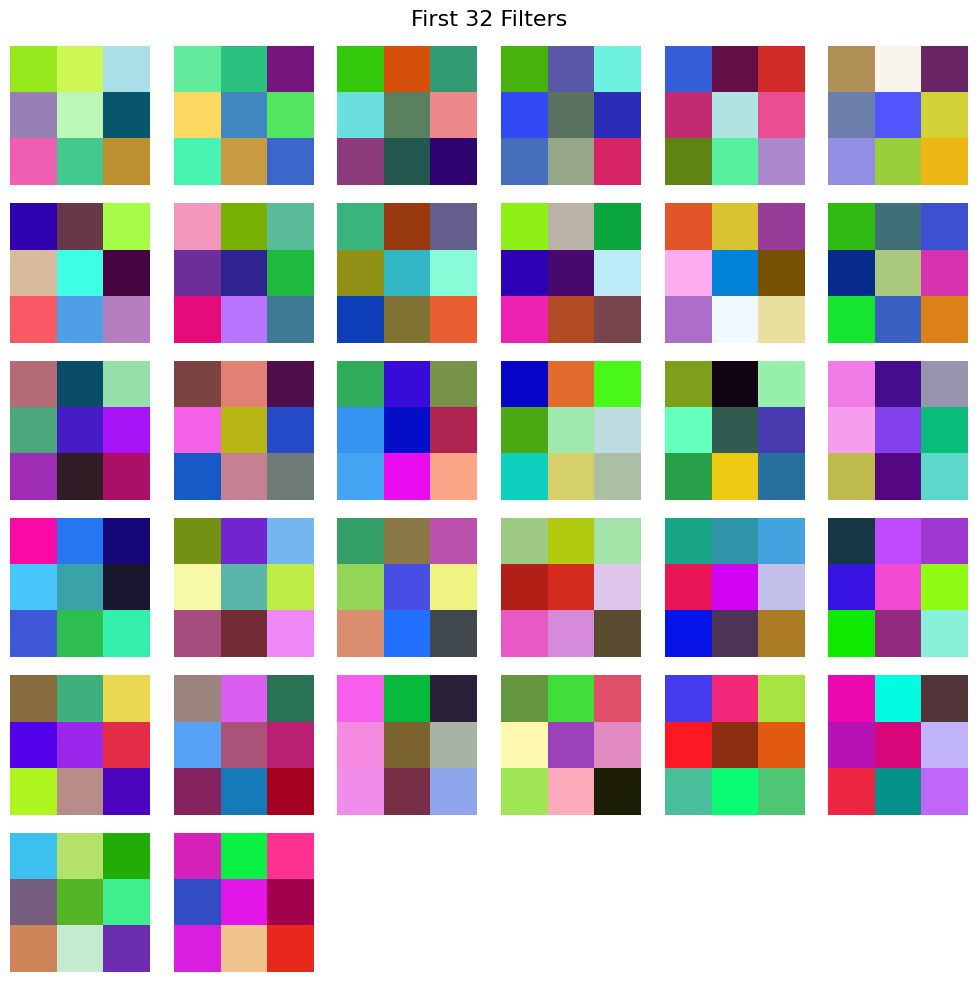

In [12]:
# Compare with random (untrained) filters
random_model = models.load_simple_cnn(num_classes=10)  # Fresh model
print("Random (Untrained) Filters:")
visualize.visualize_filters(random_model.conv1, num_filters=32)


## 6. Gradient-Based Interpretability: Saliency Maps

### Theoretical Foundation

**Saliency maps** (also called *vanilla gradients* or *input attribution*) identify which input pixels most influence the model's prediction by computing:

$$S = \left| \frac{\partial y^c}{\partial \mathbf{x}} \right|$$

where:
- $y^c$ = Pre-softmax score for target class $c$
- $\mathbf{x}$ = Input image pixels
- $S$ = Saliency map (same spatial dimensions as input)

### Algorithm

1. **Forward pass**: Compute prediction $y^c$
2. **Backward pass**: Compute gradient $\nabla_{\mathbf{x}} y^c$
3. **Aggregate channels**: Take max or mean across RGB
4. **Absolute value**: $S = |\nabla_{\mathbf{x}} y^c|$

### Mathematical Interpretation

The gradient represents the **local sensitivity** of the output to input perturbations:

$$\Delta y^c \approx \nabla_{\mathbf{x}} y^c \cdot \Delta \mathbf{x}$$

High gradient magnitude → Small input change causes large output change → **Important pixel**.

### Limitations

- **Noisy**: Gradients can be high-frequency and visually noisy
- **Saturation**: ReLU gradients are zero where activations are negative
- **Local**: Only captures first-order effects

Advanced methods like **Integrated Gradients** and **SmoothGrad** address these issues.


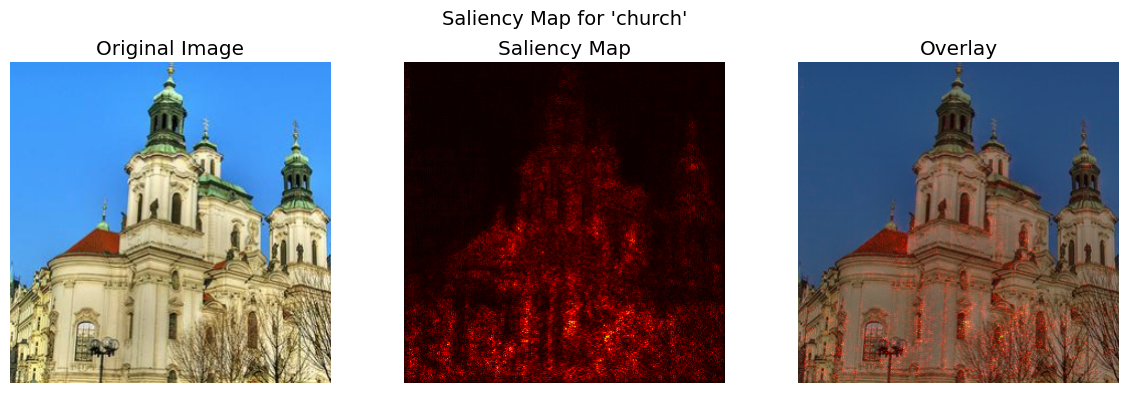

In [13]:
# Compute saliency map for our sample image
model.eval()
saliency = visualize.compute_saliency_map(
    model=model,
    input_tensor=sample_img,
    target_class=sample_label.item(),
    device=device
)

# Visualize
visualize.visualize_saliency(
    input_tensor=sample_images[0],
    saliency_map=saliency,
    title=f"Saliency Map for '{classes[sample_label]}'"
)


## 7. Class Activation Mapping (Grad-CAM)

### Theoretical Foundation

**Gradient-weighted Class Activation Mapping (Grad-CAM)** produces coarse localization maps highlighting important regions for a target class $c$. Unlike saliency maps, Grad-CAM operates on **feature maps** rather than input pixels.

### The Grad-CAM Formula

**Step 1: Compute importance weights**

$$\alpha_k^c = \underbrace{\frac{1}{Z} \sum_i \sum_j}_{\text{global avg pool}} \frac{\partial y^c}{\partial A_{ij}^k}$$

where:
- $A^k$ = Feature map $k$ from the target convolutional layer
- $y^c$ = Score for class $c$ (before softmax)
- $Z$ = Number of pixels in the feature map

**Step 2: Weighted combination with ReLU**

$$L_{\text{Grad-CAM}}^c = \text{ReLU}\left(\sum_k \alpha_k^c A^k\right)$$

The ReLU ensures we only visualize features with **positive influence** on the target class.

### Why Grad-CAM Works

| Property | Saliency Maps | Grad-CAM |
|----------|--------------|----------|
| Resolution | Pixel-level (high) | Feature-level (coarse) |
| Noise | High-frequency noise | Smooth heatmap |
| Interpretation | Which pixels matter | Which *regions* matter |
| Class-discriminative | Yes | Yes |

### Reference

> Selvaraju et al., "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization", ICCV 2017.


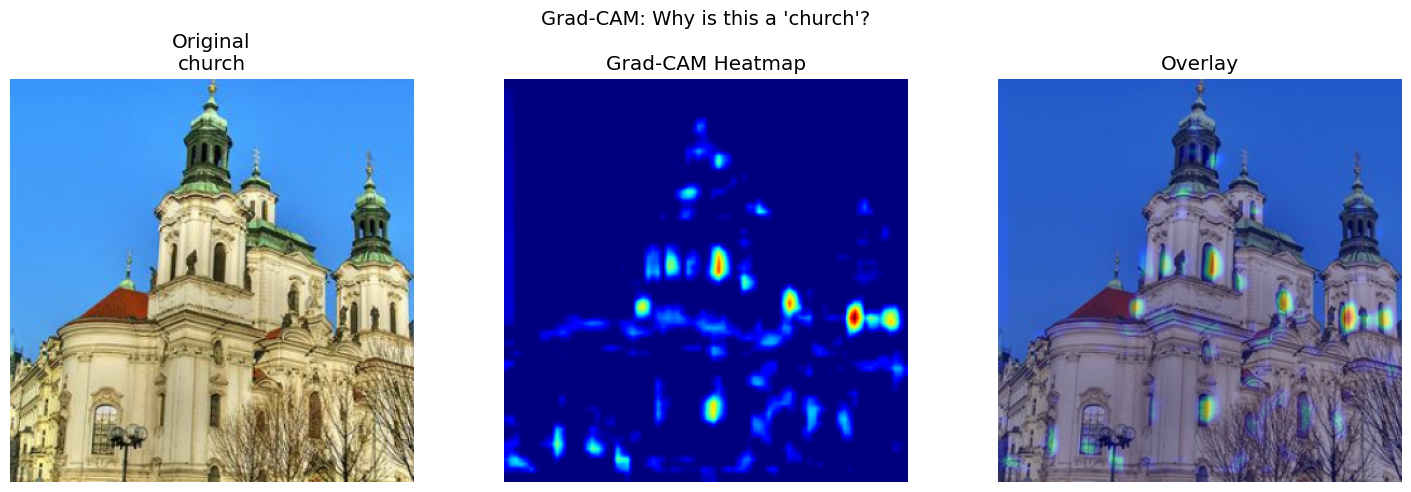

In [14]:
# Compute Grad-CAM for our trained SimpleCNN
# We need to get the last conv layer
target_layer = model.conv3

gradcam = visualize.GradCAM(model, target_layer)
heatmap = gradcam(
    input_tensor=sample_img,
    target_class=sample_label.item(),
    device=device
)

# Visualize
visualize.visualize_gradcam(
    input_tensor=sample_images[0],
    heatmap=heatmap,
    predicted_class=classes[sample_label],
    title=f"Grad-CAM: Why is this a '{classes[sample_label]}'?"
)


## 8. Deep Interpretability with InceptionV1

### InceptionV1 (GoogLeNet) Architecture

InceptionV1 introduced the **Inception module**, which processes input through parallel convolutions of different sizes:

```
        Input
          │
    ┌─────┼─────┬─────┐
    │     │     │     │
   1×1   3×3   5×5  MaxPool
    │     │     │     │
    └─────┴─────┴─────┘
          │
     Concatenate
```

### Why InceptionV1 for Interpretability?

1. **Multi-scale features**: Parallel branches capture patterns at different spatial scales
2. **Rich representations**: Concatenation creates diverse feature maps
3. **Distill.pub research**: Extensively studied for feature visualization (Olah et al., 2017)
4. **Pretrained on ImageNet**: 1000 classes, robust feature learning

### Network Depth and Interpretability

| Layer | Example Content | Interpretability |
|-------|----------------|------------------|
| `conv1` | Gabor-like edges | Easy to interpret |
| `inception3a` | Texture combinations | Moderate |
| `inception4a` | Object parts | Harder to interpret |
| `inception5b` | Full objects | Most abstract |

### Key Insight

> The deeper the layer, the more **class-specific** and **abstract** the features become. Grad-CAM on `inception5b` highlights semantic regions relevant to the predicted class.


✅ InceptionV1 (GoogLeNet) loaded!


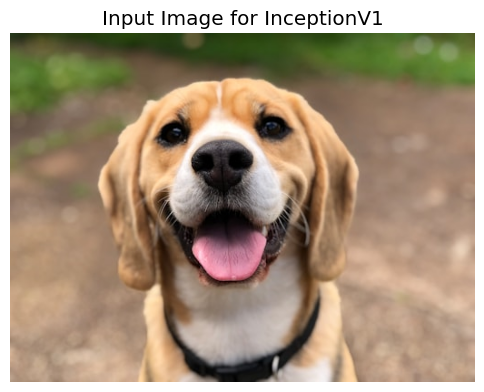

🏆 Top 5 Predictions:
  1. Beagle: 76.19%
  2. English foxhound: 8.66%
  3. Treeing Walker Coonhound: 6.45%
  4. Labrador Retriever: 1.36%
  5. Redbone Coonhound: 1.19%


In [15]:
# Load pretrained InceptionV1
inception = models.load_inception_v1(pretrained=True).to(device)
print("✅ InceptionV1 (GoogLeNet) loaded!")

# Download a sample image for InceptionV1 demo
from PIL import Image
import requests
from io import BytesIO

sample_url = "https://images.unsplash.com/photo-1543466835-00a7907e9de1?ixlib=rb-4.0.3&q=85&fm=jpg&crop=entropy&cs=srgb&w=512"
response = requests.get(sample_url)
sample_pil_image = Image.open(BytesIO(response.content)).convert('RGB')

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(sample_pil_image)
plt.axis('off')
plt.title("Input Image for InceptionV1")
plt.show()

# Preprocess image for Inception (224x224)
inception_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply transform to PIL image
inception_input = inception_transform(sample_pil_image).unsqueeze(0).to(device)

# Get prediction
with torch.no_grad():
    output = inception(inception_input)
    probs = F.softmax(output[0], dim=0)
    top5_prob, top5_idx = probs.topk(5)

# Load ImageNet labels
import json
import urllib.request
LABELS_URL = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
with urllib.request.urlopen(LABELS_URL) as url:
    imagenet_labels = json.loads(url.read().decode())

print("🏆 Top 5 Predictions:")
for i, (prob, idx) in enumerate(zip(top5_prob, top5_idx)):
    print(f"  {i+1}. {imagenet_labels[idx]}: {prob:.2%}")


InceptionV1 First Layer Filters:


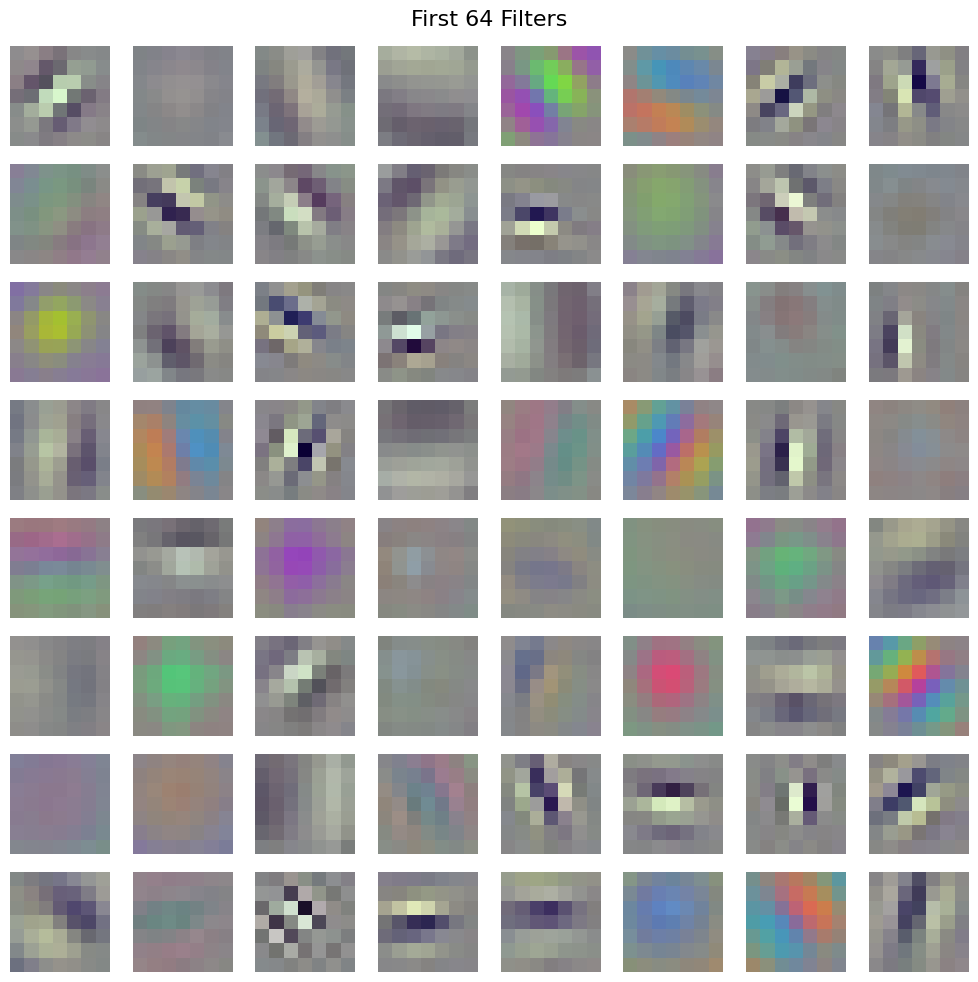

In [16]:
# Visualize InceptionV1 first layer filters
print("InceptionV1 First Layer Filters:")
visualize.visualize_filters(inception.conv1.conv, num_filters=64)


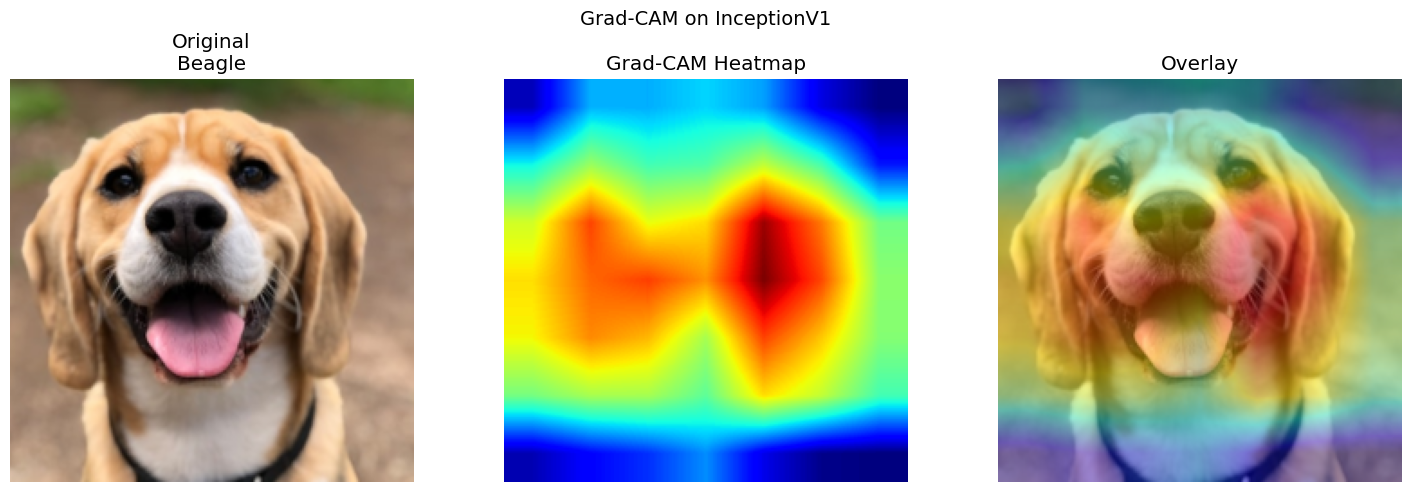

In [17]:
# Grad-CAM on InceptionV1
# Target the last conv layer before the GAP (inception5b)
inception_target_layer = inception.inception5b

inception_gradcam = visualize.GradCAM(inception, inception_target_layer.branch4[1])
inception_heatmap = inception_gradcam(
    input_tensor=inception_input,
    target_class=top5_idx[0].item(),
    device=device
)

# Visualize
visualize.visualize_gradcam(
    input_tensor=inception_input.squeeze(0),
    heatmap=inception_heatmap,
    predicted_class=imagenet_labels[top5_idx[0]],
    title=f"Grad-CAM on InceptionV1"
)


## 9. Summary

### Methods Covered

| Technique | Question Answered | Mathematical Core | Output |
|-----------|------------------|-------------------|--------|
| **Feature Maps** | Where did the model detect patterns? | $A^k = \sigma(W^k * X + b^k)$ | Activation grids |
| **Filter Visualization** | What patterns is it looking for? | Visualize $W^k$ directly | Kernel weights as images |
| **Saliency Maps** | Which pixels influenced the prediction? | $S = \|\nabla_x y^c\|$ | Gradient-based heatmap |
| **Grad-CAM** | Which *regions* were important? | $L^c = \text{ReLU}(\sum_k \alpha_k^c A^k)$ | Coarse localization heatmap |

### The Interpretability Stack

```
┌──────────────────────────────────┐
│     High-Level Explanations      │  ← Grad-CAM, CAM
├──────────────────────────────────┤
│       Feature Attribution        │  ← Saliency, Integrated Gradients
├──────────────────────────────────┤
│     Internal Representations     │  ← Feature maps, filter visualization
├──────────────────────────────────┤
│         Model Parameters         │  ← Weight analysis
└──────────────────────────────────┘
```

### Practical Applications

1. **Model debugging**: Find spurious correlations (e.g., model focusing on background)
2. **Trust building**: Show users *why* a medical AI made a diagnosis
3. **Research**: Understand how CNNs develop hierarchical representations
4. **Adversarial robustness**: Detect when models rely on fragile features

### Further Reading

- [Distill.pub Feature Visualization](https://distill.pub/2017/feature-visualization/)
- [Grad-CAM Paper (ICCV 2017)](https://arxiv.org/abs/1610.02391)
- [Captum Library](https://captum.ai/) — PyTorch interpretability toolkit


In [18]:
print("🎉 Congratulations! You've completed the Vision Interpretability tutorial!")
print("\n📚 Resources:")
print("  - Grad-CAM Paper: https://arxiv.org/abs/1610.02391")
print("  - Captum (PyTorch Interpretability): https://captum.ai/")
print("  - ImageNette Dataset: https://huggingface.co/datasets/frgfm/imagenette")


🎉 Congratulations! You've completed the Vision Interpretability tutorial!

📚 Resources:
  - Grad-CAM Paper: https://arxiv.org/abs/1610.02391
  - Captum (PyTorch Interpretability): https://captum.ai/
  - ImageNette Dataset: https://huggingface.co/datasets/frgfm/imagenette
